# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus Project

**⚠️ Important Notice**: This notebook was AI-generated and has not been fully verified. Please exercise caution when interpreting the code or results. Always validate the outputs and analyses for your specific research needs.

## Overview

This notebook explores Dandiset 000690, which contains data from the Vision2Hippocampus project at the Allen Institute. The project investigates how visual representations evolve from the thalamus through various brain regions to the hippocampus in mice. Specifically, it examines how neural representations of both simple visual stimuli (like light bars) and complex natural stimuli (like eagle videos) are processed across different brain regions.

View this dataset on DANDI: [https://dandiarchive.org/dandiset/000690](https://dandiarchive.org/dandiset/000690)

## Required Packages

This notebook uses the following Python packages:
* `pynwb` - for reading NWB files
* `h5py` - for handling HDF5 files
* `remfile` - for remote file access
* `numpy` - for numerical operations
* `matplotlib` - for plotting
* `pandas` - for data manipulation
* `seaborn` - for enhanced plotting

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set up plotting style
sns.set_theme()

## Loading the Dataset

We'll explore data from subject 692072, specifically looking at the LFP (Local Field Potential) data from probe 0. This subject is a male transgenic mouse that was 82 days old at the time of recording.

In [2]:
# Load the NWB file
url = "https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic information about the recording session
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Age: {nwb.subject.age} ({nwb.subject.age_in_days} days)")
print(f"Sex: {nwb.subject.sex}")
print(f"Species: {nwb.subject.species}")
print(f"Session ID: {nwb.session_id}")
print(f"Session Start Time: {nwb.session_start_time}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Subject ID: 692072
Age: P82D (82.0 days)
Sex: M
Species: Mus musculus
Session ID: 1298465622
Session Start Time: 2023-09-21 00:00:00-07:00


## Exploring Electrode Information

Let's examine the electrode configuration and brain regions covered by probe 0.

In [3]:
# Get electrode information as a pandas DataFrame
electrodes_df = nwb.electrodes.to_dataframe()

# Display basic statistics about electrode locations
print("Brain regions covered by the electrodes:")
print(electrodes_df['location'].value_counts())

print("\nNumber of valid channels:", electrodes_df['valid_data'].sum())

Brain regions covered by the electrodes:
location
CA1          23
LP           16
DG-mo        12
RSPagl5       9
root          8
DG-sg         6
RSPagl2/3     5
RSPagl6a      4
TH            3
RSPagl1       3
VISa6a        2
DG-po         2
PF            1
VISa6b        1
Name: count, dtype: int64

Number of valid channels: 95


## Accessing LFP Data

The LFP data is sampled at 625 Hz and contains recordings from 95 channels. Let's examine a short segment of the data.

LFP data shape: (10117092, 95)
Sampling rate: 625.0 Hz
Duration: 16187.35 seconds


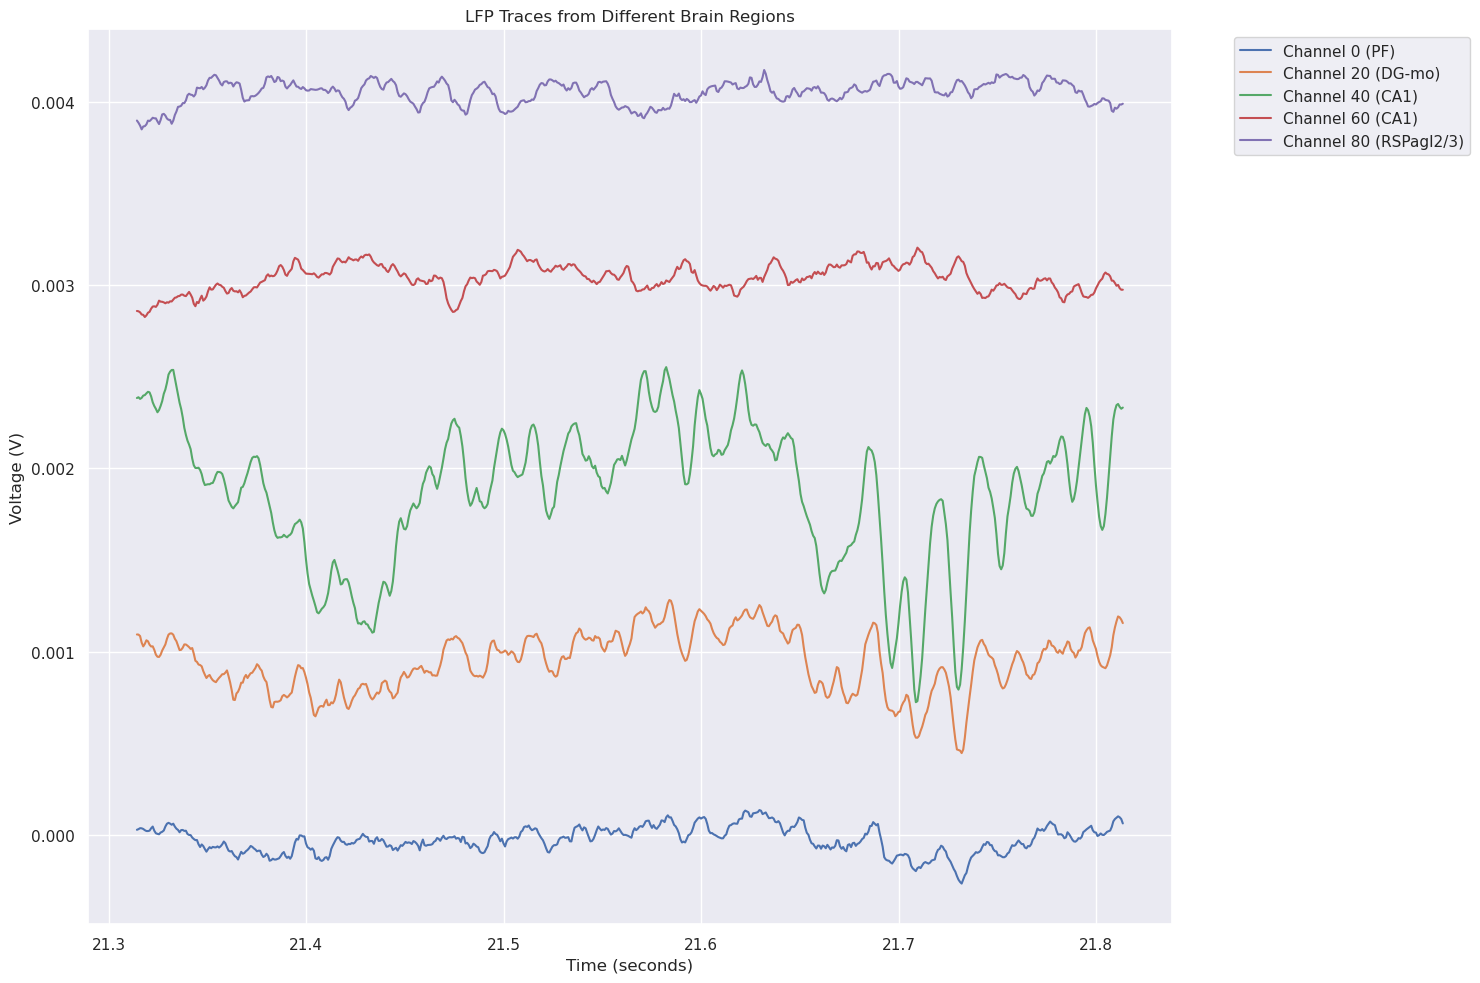

In [4]:
# Get the LFP data
lfp_data = nwb.acquisition['probe_0_lfp_data']
print(f"LFP data shape: {lfp_data.data.shape}")
print(f"Sampling rate: {nwb.electrode_groups['probeA'].lfp_sampling_rate} Hz")
print(f"Duration: {len(lfp_data.timestamps)/625:.2f} seconds")

# Let's plot 1 second of data from a few channels
start_time = 1000  # start at 1000th sample
duration = 625     # plot 1 second (625 samples)
channels_to_plot = [0, 20, 40, 60, 80]  # Select a few channels spread across the probe

plt.figure(figsize=(15, 10))
for i, channel in enumerate(channels_to_plot):
    # Get the channel location
    location = electrodes_df.iloc[channel]['location']
    # Plot the trace with offset for visibility
    offset = i * 0.001  # Add offset to separate traces
    data = lfp_data.data[start_time:start_time+duration, channel]
    plt.plot(lfp_data.timestamps[start_time:start_time+duration], 
             data + offset, 
             label=f'Channel {channel} ({location})')

plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title('LFP Traces from Different Brain Regions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Visualizing Electrode Positions

Let's create a visualization of the electrode positions along the probe.

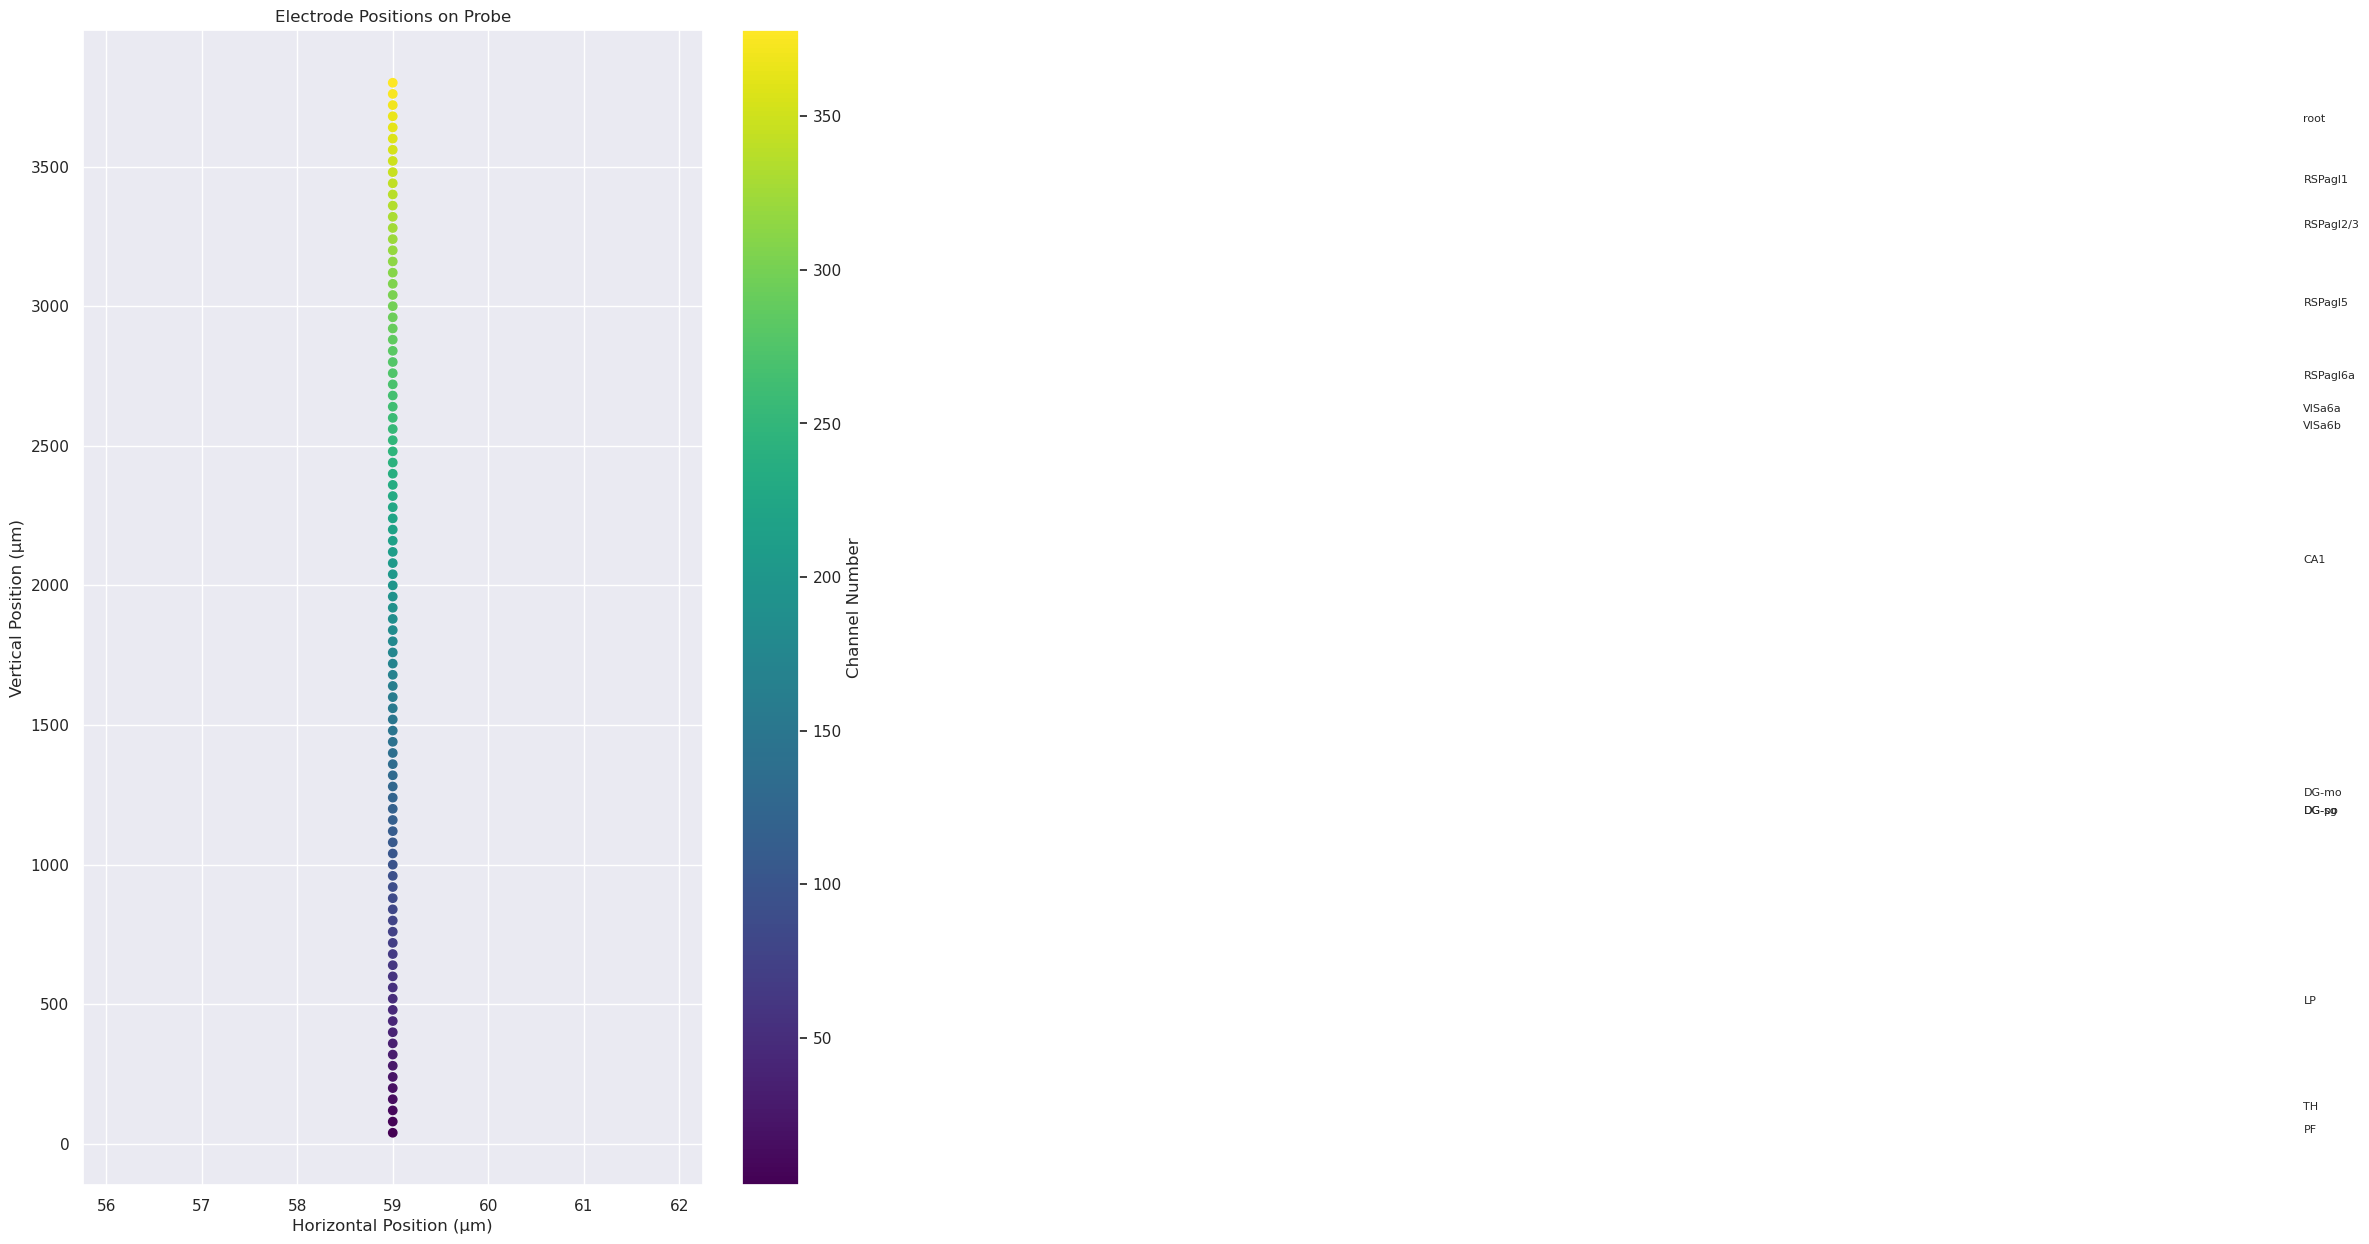

In [5]:
plt.figure(figsize=(10, 15))
plt.scatter(electrodes_df['probe_horizontal_position'], 
           electrodes_df['probe_vertical_position'],
           c=electrodes_df.index,
           cmap='viridis')

# Add labels for different brain regions
for region in electrodes_df['location'].unique():
    region_data = electrodes_df[electrodes_df['location'] == region]
    mean_x = region_data['probe_horizontal_position'].mean()
    mean_y = region_data['probe_vertical_position'].mean()
    plt.text(mean_x + 20, mean_y, region, fontsize=8)

plt.xlabel('Horizontal Position (µm)')
plt.ylabel('Vertical Position (µm)')
plt.title('Electrode Positions on Probe')
plt.colorbar(label='Channel Number')
plt.grid(True)
plt.show()

## Computing Power Spectral Density

Let's compute and visualize the power spectral density for channels in different brain regions.

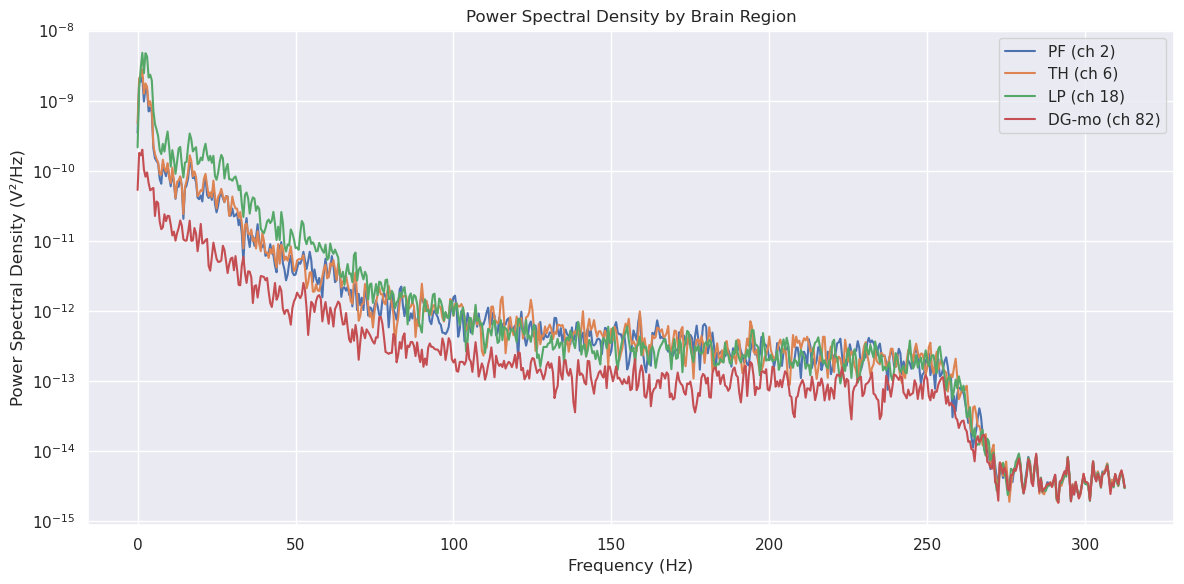

In [6]:
from scipy import signal

# Select a channel from each region, ensuring it's within valid range
sample_channels = []
for region in electrodes_df['location'].unique():
    # Get valid channels for this region
    valid_channels = electrodes_df[
        (electrodes_df['location'] == region) & 
        (electrodes_df.index < 95)  # Ensure within range
    ].index
    if len(valid_channels) > 0:
        sample_channels.append((region, valid_channels[0]))

# Compute PSD for a 10-second segment
segment_length = 6250  # 10 seconds * 625 Hz
start_time = 1000

plt.figure(figsize=(12, 6))
for region, channel in sample_channels:
    # Get data for this channel
    data = lfp_data.data[start_time:start_time+segment_length, channel]
    
    # Compute PSD using Welch's method
    f, psd = signal.welch(data, fs=625, nperseg=1250)
    
    # Plot
    plt.semilogy(f, psd, label=f"{region} (ch {channel})")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')
plt.title('Power Spectral Density by Brain Region')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary and Future Directions

This notebook demonstrated how to:
1. Load and access LFP data from a Vision2Hippocampus dataset
2. Examine electrode positions and brain regions
3. Visualize raw LFP traces from different channels
4. Analyze frequency content across brain regions

Potential future analyses could include:
- Investigating temporal correlations between regions during visual stimulation
- Analyzing phase relationships between different brain areas
- Computing coherence between regions
- Examining how LFP patterns change in response to different visual stimuli

To explore this dataset further, you can:
- Access the full dataset at https://dandiarchive.org/dandiset/000690
- View this specific NWB file in NeurosiftHub: https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/ba8760f9-91fe-4c1c-97e6-590bed6a783b/download/&dandisetId=000690&dandisetVersion=draft